# Introduction

Kapten is a french ride hailing plateform which matches users asking for rides with drivers. 
When a user commands a ride, we announce to him an estimated eta (estimated time of arrival) of the driver. 
Unfortunately, the eta can be different from the rta (real time of approach): This leads to a bad user experience (frustration, ride cancellation, ...) .

Since Kapten's strategy is based on customer satisfaction and transparency, we want the eta to be as close as possible to the rta.

# Your mission

We will give you a csv that contains many rides data. Your mission is to use this data source in order to help Kapten to improve its etas exactness by using machine learning algorithms.

## Columns definition

The csv contains the following columns:

- `command_date`: The command date.
- `bird_flight_distance`: The bird flight distance (in meters) that separes the driver and the user.
- `car_type`: The driver's car type.
- `surge`: The surge coefficient (During peak hours, we multiply rides prices by this coefficient)
- `address`: The ride's start address.
- `is_from_airport`: A boolean indicating whether the ride starts from an airport or not.
- `eta`: The estimated time of arrival.
- `rta`: The real time of arrival

Your target variable is the column `rta`, you can use all the other variables as input for your algorithm.


### P.S

Please, do not spend more than three hours on this test. Our goal is not to have an exact solution but to test your approach when dealing with a machine learning problems.

# Step by Step:
During this test, we will guide you throught many sections:
    - Data analysis
    - Handle empty data and outliers
    - Apply one machine learning algorithm
    - Conclusion.
 
For each section, you can add as cells as possible.
Please, do not hesitate to add another section or cells if you think it is necessary.

In [614]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from scipy.stats import pearsonr

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Linear Models
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge


from sklearn.model_selection import cross_validate

In [545]:
# Read data
etas_df = pd.read_csv('etas_data.csv')

## 0. Dataset quick Analysis

In [546]:
def overview_features(df):
    """
    Returns the ratio of nulls values, type and cardinality of each feature"""
    columns = df.columns
    types = df.dtypes.values
    cardinality = df.nunique().values
    nulls = df.isnull().sum()
    nulls_ratio = ((df.isnull().sum() / len(df)).values * 100).round(2)

    df_desc = pd.DataFrame({'Feat'       : columns, 
                            'Nulls'      : nulls,
                            'Nulls (%)'  : nulls_ratio, 
                            'Type'       : types, 
                            'Cardinality': cardinality}).set_index('Feat').sort_values(by='Cardinality')
    df_desc.Type.value_counts()
    
    return df_desc


In [547]:
print('Dataframe shape:', etas_df.shape)
etas_df.head(2)

Dataframe shape: (30000, 8)


,command_date,bird_flight_distance,car_type,surge,address,is_from_airport,eta,rta
0,2018-01-09 20:59:39.929000+00:00,265.707401,standard,1.0,86 Rue du Point du Jour,False,69,134
1,2018-01-09 19:01:31.441000+00:00,265.131829,standard,1.0,6 Rue Duret,False,232,208


In [548]:
overview_features(etas_df)

,Nulls,Nulls (%),Type,Cardinality
Feat,,,,
is_from_airport,1554,5.18,object,2
car_type,0,0.00,object,3
surge,5967,19.89,float64,10
eta,0,0.00,int64,1263
rta,0,0.00,int64,1467
address,0,0.00,object,20209
bird_flight_distance,5,0.02,float64,29963
command_date,0,0.00,object,29997


**Observations:**
    
- 2 features with many missing values
- 3 features with low cardinality

#### Time range

In [549]:
print('From {} to {}'.format(min(etas_df.command_date), max(etas_df.command_date)))

From 2018-01-08 11:01:27.577000+00:00 to 2018-01-17 10:59:55.806000+00:00


- Less than 10 days of data

#### Duplicate rows ?

In [550]:
# Rows containing duplicate data
duplicate_rows_df = etas_df[etas_df.duplicated()]
print("number of duplicate rows: {}".format(duplicate_rows_df.shape[0]))

number of duplicate rows: 1


In [551]:
duplicate_rows_df.head()

,command_date,bird_flight_distance,car_type,surge,address,is_from_airport,eta,rta
29678,2018-01-16 22:57:00+00:00,NaN,standard,1.0,26 Rue François 1er,False,0,0


In [68]:
etas_df[etas_df.command_date == '2018-01-16 22:57:00+00:00']

,command_date,bird_flight_distance,car_type,surge,address,is_from_airport,eta,rta
5082,2018-01-16 22:57:00+00:00,NaN,standard,1.0,26 Rue François 1er,False,0,0
29678,2018-01-16 22:57:00+00:00,NaN,standard,1.0,26 Rue François 1er,False,0,0


> I will keep it for now and remove it later

## 1. Data analysis

During this section, you have to analyse so briefly (in few lines) each of the following variables. 
Data visualization will be a plus

### 1.1: bird_flight_distance analysis

In [552]:
feature = 'bird_flight_distance'

- Continuous feature
- Very few missing values: 5 (0.02%)

In [553]:
# Missing values
etas_df[etas_df[feature].isnull()]

,command_date,bird_flight_distance,car_type,surge,address,is_from_airport,eta,rta
5082,2018-01-16 22:57:00+00:00,NaN,standard,1.0,26 Rue François 1er,False,0,0
19144,2018-01-11 17:09:29.059000+00:00,NaN,standard,1.0,3 Rue Aristide Briand,False,237,201
23239,2018-01-10 18:27:00+00:00,NaN,standard,1.0,82 Rue Henry Farman,False,0,0
26366,2018-01-14 12:59:00+00:00,NaN,standard,1.0,Aéroport de Paris - Orly,True,0,0
29678,2018-01-16 22:57:00+00:00,NaN,standard,1.0,26 Rue François 1er,False,0,0


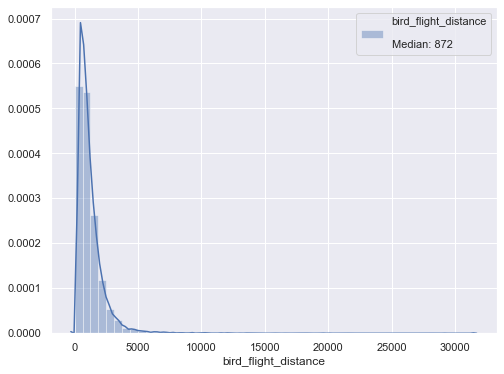

In [92]:
plt.figure(figsize=(8,6))
sns.distplot(etas_df[feature][~np.isnan(etas_df[feature])], 
             label='bird_flight_distance\n\nMedian: {}'.format(int(etas_df[feature].median())))
plt.legend()

In [94]:
print('Mean value {}'.format(etas_df[feature].mean()))
print('Median value {}'.format(etas_df[feature].median()))

Mean value 1162.0907570794889
Median value 872.1154930346028


- We can observe some points with very high values compared to the rest

> Since 4 out of the 5 rows containing missing value have an eta=rta=0, let us see if the rows with eta=rta=0 have any specificity

In [554]:
etas_df[(etas_df['eta'] == 0) & (etas_df['rta'] == 0)]

,command_date,bird_flight_distance,car_type,surge,address,is_from_airport,eta,rta
5082,2018-01-16 22:57:00+00:00,NaN,standard,1.0,26 Rue François 1er,False,0,0
23239,2018-01-10 18:27:00+00:00,NaN,standard,1.0,82 Rue Henry Farman,False,0,0
26366,2018-01-14 12:59:00+00:00,NaN,standard,1.0,Aéroport de Paris - Orly,True,0,0
29678,2018-01-16 22:57:00+00:00,NaN,standard,1.0,26 Rue François 1er,False,0,0


In [555]:
etas_df[etas_df['rta'] == 0]

,command_date,bird_flight_distance,car_type,surge,address,is_from_airport,eta,rta
5082,2018-01-16 22:57:00+00:00,NaN,standard,1.0,26 Rue François 1er,False,0,0
23239,2018-01-10 18:27:00+00:00,NaN,standard,1.0,82 Rue Henry Farman,False,0,0
26366,2018-01-14 12:59:00+00:00,NaN,standard,1.0,Aéroport de Paris - Orly,True,0,0
29678,2018-01-16 22:57:00+00:00,NaN,standard,1.0,26 Rue François 1er,False,0,0


When the rta=0 we only have 4 observations. These rows can be bugs of the driver accepted directly the demand. I need to know more about this feature to choose between these two options:
- Consider them as outliers 
- Replace NaN by 0 : rta=0 -> distance=0

Text(0, 0.5, 'rta')

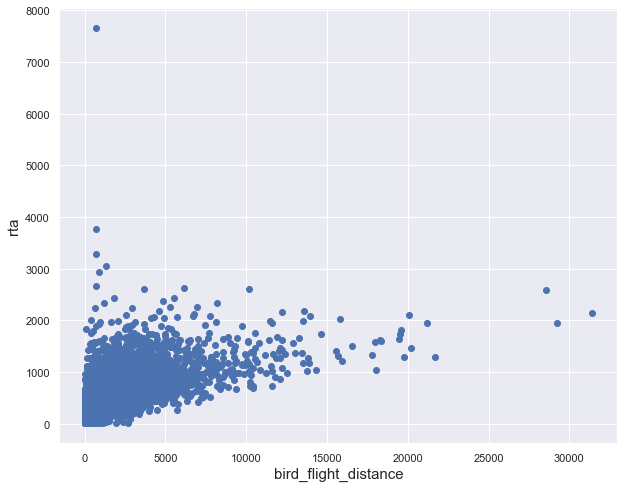

In [559]:
plt.figure(figsize=(10,8))
plt.scatter(etas_df['bird_flight_distance'], etas_df['rta'])
plt.xlabel('bird_flight_distance', fontsize=15)
plt.ylabel('rta', fontsize=15)

- Here the dot at the top left looks like an outlier: waiting the driver for more than 2 hours for such a low distance seems weird. I will consider it as an outlier 
- I have some doubt when rta > 1 hour but I will keep them (I need to know more about these particular observations)

- Concerning the dots at the bottom right, I cannot say if they are outliers or not, since they seem to belong to a line that represents the trend of : the more the distance is high the more it takes time
- There might be another hub and trend when distance is low but rta is high (for trips inside city with traffic jam)

<Figure size 720x576 with 0 Axes>

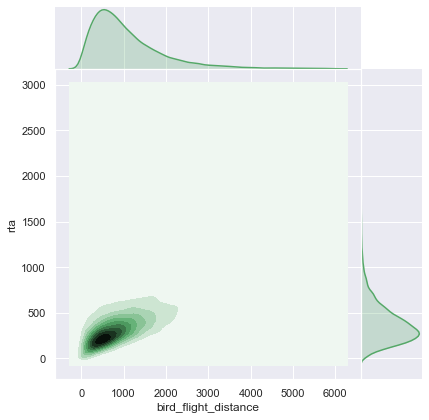

In [563]:
plt.figure(figsize=(10,8))

df_temp = etas_df[(etas_df['rta'] < 3000) & (etas_df['bird_flight_distance'] < 6000)]
sns.jointplot('bird_flight_distance', 'rta', data=df_temp,
                           kind="kde", space=0, color="g")

In [85]:
etas_df[etas_df.rta > 3000]

,command_date,bird_flight_distance,car_type,surge,address,is_from_airport,eta,rta
5898,2018-01-09 13:12:37.940000+00:00,728.487757,standard,1.0,54 Rue de la Balme,False,313,3767
12776,2018-01-11 11:28:50.999000+00:00,1298.902661,standard,1.0,"44 Rue Traversière, • 92772 Boulogne-Billancou...",False,228,3051
22909,2018-01-09 06:53:56.934000+00:00,730.666589,standard,1.0,9 Place de la Bourse,False,301,7656
26227,2018-01-17 04:10:10.846000+00:00,692.590552,standard,1.0,1 Rue du Four,False,88,3287


> When looking at the outliers that appear in the plot above, it appears that there was a particular problem since the rta is more than 10 times higher than the eta

In [110]:
# calculate Pearson's correlation
corr, _ = pearsonr(etas_df['rta'][~np.isnan(etas_df['bird_flight_distance'])], 
                   etas_df['bird_flight_distance'][~np.isnan(etas_df['bird_flight_distance'])])
print('Pearsons correlation: {}'.format(round(corr, 3)))

Pearsons correlation: 0.622


> This feature has an interesting linear correlation with the target 'rta'

### 1.2: car_type analysis

In [564]:
feature = 'car_type'

- Categorical feature
- Low caridnality: 3
- No missing values

In [565]:
cars_df = etas_df[feature].value_counts().to_frame(name='count')
cars_df['ratio(%)'] = cars_df['count'] / len(etas_df) * 100
cars_df

,count,ratio(%)
standard,28935,96.45
sedan,813,2.71
van,252,0.84


- Majority of standard cars

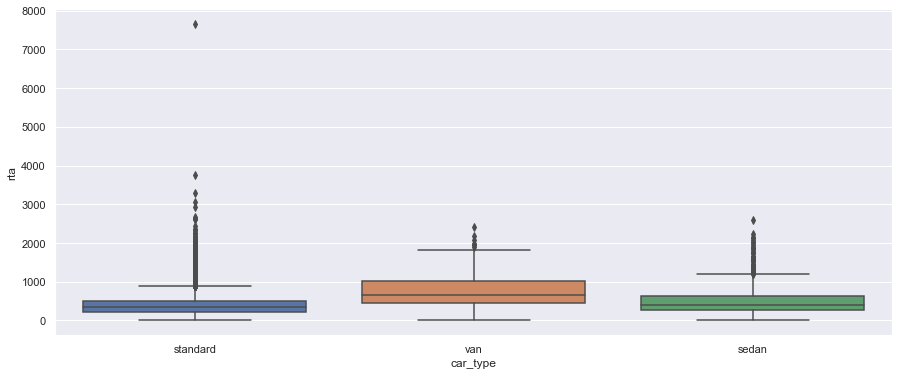

In [566]:
plt.figure(figsize=(15,6))
sns.boxplot(x=feature, y='rta', data=etas_df)

> We observe a noticeable distinction of 'rta' distribution between 'van' and 'standard' car types 

> Which is expectable since vans are rarer than standard cars

### 1.3:  surge analysis

In [568]:
feature = 'surge'

- Ordinal feature
- Low cardinality: 10 
- Many missing values 5967 (20%)

In [569]:
surge_df = etas_df[feature].value_counts().to_frame(name='count')
surge_df['ratio(%)'] = surge_df['count'] / len(etas_df) * 100

surge_df

,count,ratio(%)
1.0,16894,56.313333
1.4,1668,5.560000
1.2,1323,4.410000
1.3,847,2.823333
1.9,721,2.403333
1.6,695,2.316667
1.5,677,2.256667
1.7,674,2.246667
1.8,533,1.776667
2.1,1,0.003333


> Here the observation with surge=2.1 is unique and can be remove as an outlier

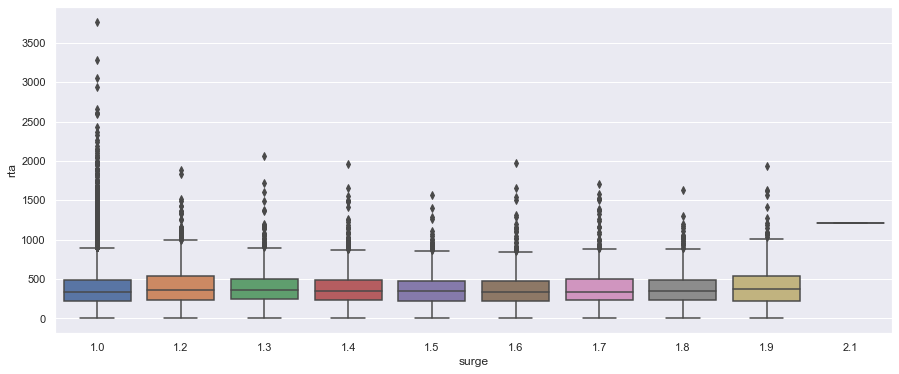

In [570]:
plt.figure(figsize=(15,6))
sns.boxplot(x=feature, y='rta', data=etas_df[etas_df.rta < 7000])

> There is not much distinction between classes 

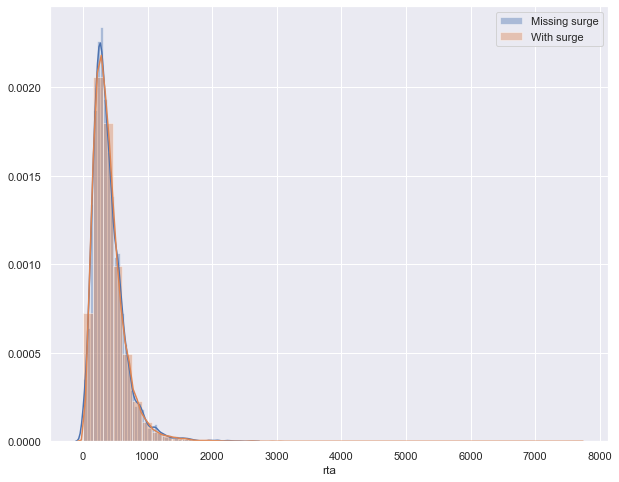

In [131]:
plt.figure(figsize=(10,8))
sns.distplot(etas_df[etas_df[feature].isnull()].rta, label='Missing surge')
sns.distplot(etas_df[~etas_df[feature].isnull()].rta, label='With surge')
plt.legend()

- The plot above shows that missing values are missing at random. Which is important to know. Missing surge value have no particular meaning and do know point a special behavior of RTA

### 1.4: is_from_airport analysis

In [571]:
feature = 'is_from_airport'

- Categorical feature
- Low cardinality: 2
- Many missing value: 1554 (5.18 %)	

In [572]:
from_airport = etas_df[feature].value_counts().to_frame(name='count_from_airports')
from_airport["ratio(%)"] = from_airport['count_from_airports'] / len(etas_df) * 100
from_airport

,count_from_airports,ratio(%)
False,27597,91.99
True,849,2.83


In [573]:
list_airports = list(etas_df[etas_df[feature] == True].address.unique())
print('Number of airports: {} \n\n{}'.format(len(list_airports), list_airports))

Number of airports: 38 

['Orly Terminal Ouest', 'CDG terminal 1', 'Roissy Terminal 2D', 'Roissy terminal 2A', 'Orly Terminal Sud', 'Roissy Terminal 2E', 'Roissy Terminal 2F', 'Aéroport de Paris - Orly', 'Terminal Ouest - Terminal Ouest - Aéroport de Paris - Orly', 'Aéroport Saint Exupéry Terminal 1', 'Terminal Ouest - Aéroport de Paris - Orly', 'Aéroport Lyon-Saint Exupéry Terminal 2', 'Roissy Terminal 2C', 'Roissy Terminal 2G', 'Terminal 2F - Aéroport de Paris - Charles-de-Gaulle', 'Terminal 2E - Aéroport de Paris - Charles-de-Gaulle', 'Terminal 1 - Aéroport de Paris - Charles-de-Gaulle', 'Roissy Terminal 3', 'Aéroport de Paris - Le Bourget', 'Terminal 2E - Terminal 2E - Aéroport de Paris - Charles-de-Gaulle', 'Orly Sud, Terminal Sud, Avenue S', 'Terminal 1 - Terminal 1 - Aéroport de Paris - Charles-de-Gaulle', 'Terminal 1 - Terminal 1 - Aéroport Lyon-Saint Exupéry', 'Terminal 2A - Terminal 2A - Aéroport de Paris - Charles-de-Gaulle', 'Terminal 2F - Terminal 2F - Aéroport de Paris - 

- This feature can be recovered from the address 

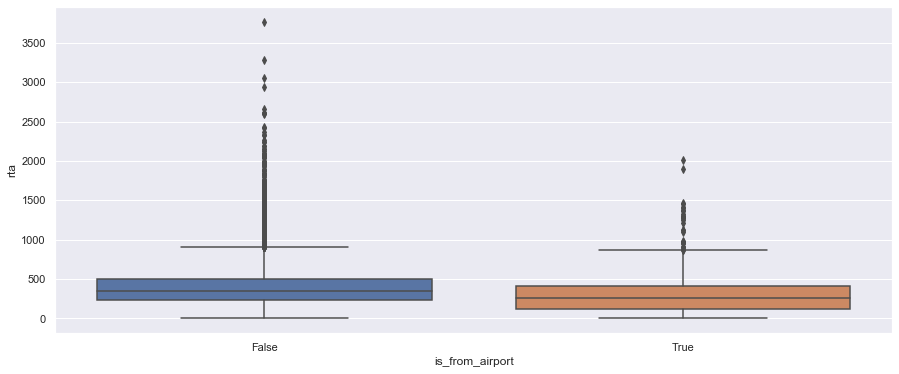

In [574]:
plt.figure(figsize=(15,6))
sns.boxplot(x=feature, y='rta', data=etas_df[etas_df.rta < 7000])

> Median rta when the call for a driver is made from an airport is lower than the one when it is not from an airport
> This is expectable since drivers are usually nearby airports (just dropped someone or waiting for a client), and if they are not, they would probably not come to the airport

### 1.5: Analyse the variable eta

- Continuous feature
- No missing data

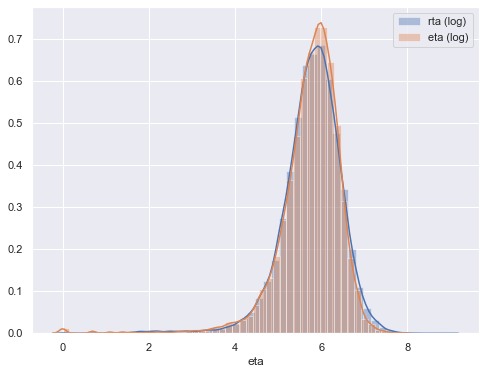

In [575]:
plt.figure(figsize=(8,6))
sns.distplot(np.log(np.maximum(etas_df['rta'], 1)), label='rta (log)')
sns.distplot(np.log(np.maximum(etas_df['eta'], 1)), label='eta (log)')
plt.legend()

- No anomaly detected here between ETA and RTA

In [576]:
# calculate Pearson's correlation
corr, _ = pearsonr(etas_df['rta'], 
                   etas_df['eta'])
print('Pearsons correlation: {}'.format(round(corr, 3)))

Pearsons correlation: 0.719


- High linear correlation between eta and rta

In [577]:
print('In average, ETA represent an error of {} (seconds ?) compared to RTA'.format(round(mean_absolute_error(etas_df['rta'],
                                                                                                 etas_df['eta']), 2)))

In average, ETA represent an error of 115.89 (seconds ?) compared to RTA


- This value is biased by outliers with very high values

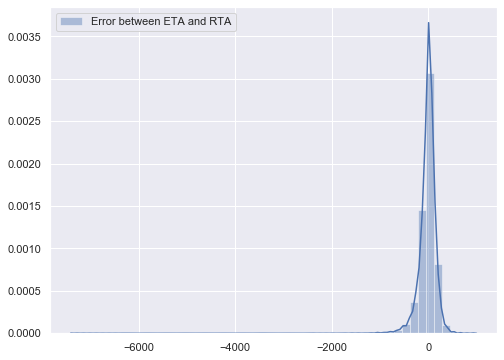

In [578]:
diff_eta_rta = etas_df.eta - etas_df.rta
plt.figure(figsize=(8,6))
sns.distplot(diff_eta_rta, label='Error between ETA and RTA')
plt.legend()
#plt.title('Target distribution', fontsize=20)

- It is reassuring to observe a gaussian centered around 0.
- However we observe that is some cases the ETA is way lower than the RTA

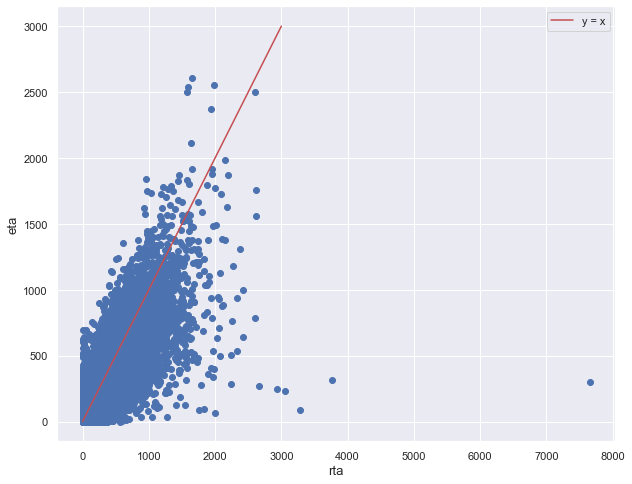

In [580]:
plt.figure(figsize=(10,8))
plt.scatter(etas_df['rta'], etas_df['eta'])
plt.xlabel('rta', fontsize=13)
plt.ylabel('eta', fontsize=13)
plt.plot([0, 1, 3000], [0, 1, 3000], c='r', label='y = x')
plt.legend()

> The dot at the bottom right seems to be an outlier. ETA is very low and RTA is very high (same dot observe at previous analysis)

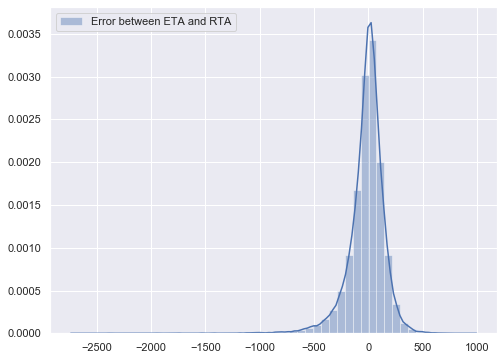

In [582]:
# When removing this dot

diff_eta_rta = df_temp.eta - df_temp.rta
plt.figure(figsize=(8,6))
sns.distplot(diff_eta_rta, label='Error between ETA and RTA')
plt.legend()
#plt.title('Target distribution', fontsize=20)

## 2. Data cleaning
In this section, you have to handle missing data and outliers.

In [583]:
clean_df = etas_df.copy()

### Missing values

**is_from_airport**

In [584]:
clean_df['new_is_from_airport'] = clean_df.address.isin(list_airports)

> If more time, it would have been more careful to check if the word airport (or others) are in address, other airports or other names might exist

**bird_flight_distance**

In [585]:
clean_df[clean_df['bird_flight_distance'].isnull()]

,command_date,bird_flight_distance,car_type,surge,address,is_from_airport,eta,rta,new_is_from_airport
5082,2018-01-16 22:57:00+00:00,NaN,standard,1.0,26 Rue François 1er,False,0,0,False
19144,2018-01-11 17:09:29.059000+00:00,NaN,standard,1.0,3 Rue Aristide Briand,False,237,201,False
23239,2018-01-10 18:27:00+00:00,NaN,standard,1.0,82 Rue Henry Farman,False,0,0,False
26366,2018-01-14 12:59:00+00:00,NaN,standard,1.0,Aéroport de Paris - Orly,True,0,0,True
29678,2018-01-16 22:57:00+00:00,NaN,standard,1.0,26 Rue François 1er,False,0,0,False


> Concerning the rows for which rta = 0, it can only mean that bird_flight_distance=0 or a bug happened 

> For the fifth row with rta != 0, I can take the average over the rows with address '3 Rue Aristide Briand', or take bird_flight_distance of the one with the closest rta. But here since it is only one row  and I will not spend much time on it, I will just remove it.

In [586]:
clean_df.drop(19144, axis=0, inplace=True)

In [587]:
clean_df.fillna(value={'bird_flight_distance': 0}, inplace=True)

**surge**

- Here I can replace the missing values by 1 (the most frequent value)
- I can also add a column with 1 or 0 indicating if surge was missing in first place or not

In [588]:
# New indicatrice column
clean_df['surge_was_missing'] = clean_df['surge'].isnull().astype(int)
clean_df.fillna(value={'surge': 1}, inplace=True)

### Outliers 

- Concerning **Surge** I am going to remove the only row containig a value of 2.1 

In [589]:
print('before: {}'.format(clean_df.shape))
clean_df = clean_df[clean_df.surge != 2.1]
print('after : {}'.format(clean_df.shape))

before: (29999, 10)
after : (29998, 10)


- Concerning **rta**, its distribution looks like a log normale
- No pics observed out of the normal 
- I will only remove the only dot that i spoke about previously

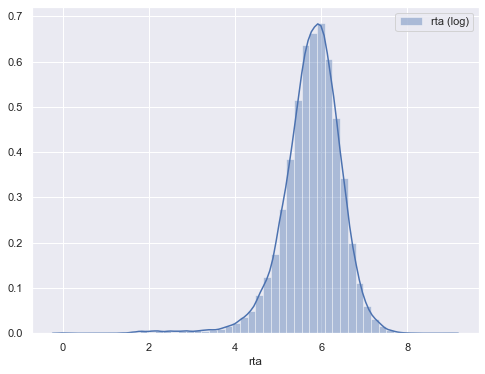

In [590]:
plt.figure(figsize=(8,6))
sns.distplot(np.log(np.maximum(clean_df['rta'], 1)), label='rta (log)')
plt.legend()

In [591]:
print('before: {}'.format(clean_df.shape))
clean_df = clean_df[clean_df.rta < 7000]
print('after : {}'.format(clean_df.shape))

before: (29998, 10)
after : (29997, 10)


- Concerning **ETA**, same as rta

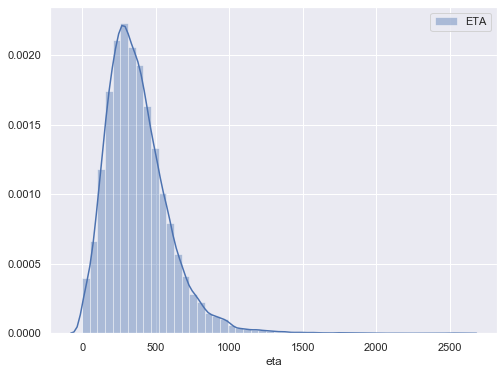

In [596]:
plt.figure(figsize=(8,6))
sns.distplot(clean_df['eta'], label='ETA')
plt.legend()

- Distribution: log-normal. Small pic at ETA = 0
- Having an ETA of 0 seems very weird. Since I don't know how they were made I will keep them. 
- Nothing seems weird in rows for which ETA = 0. Additional reason to not remove these observations (even if they would certainly improve the model performance)

In [595]:
len(clean_df[clean_df.eta == 0])
clean_df[clean_df.eta == 0]

,command_date,bird_flight_distance,car_type,surge,address,is_from_airport,eta,rta,new_is_from_airport,surge_was_missing
1264,2018-01-10 16:55:24.746000+00:00,17.284295,standard,1.0,Gare de l'Est,False,0,6,False,0
1540,2018-01-09 23:45:25.784000+00:00,11.478979,standard,1.5,47 Rue De Ponthieu,False,0,37,False,0
2046,2018-01-10 01:11:09.027000+00:00,17.303488,standard,1.0,29 Rue Chauvelot,False,0,24,False,0
3843,2018-01-12 14:33:48.518000+00:00,12.058898,standard,1.0,Roissy Terminal 2F,True,0,347,True,0
3931,2018-01-13 22:34:47.614000+00:00,2.165196,standard,1.0,CDG terminal 1,True,0,12,True,0
5082,2018-01-16 22:57:00+00:00,0.000000,standard,1.0,26 Rue François 1er,False,0,0,False,0
5176,2018-01-10 20:06:56.647000+00:00,2.572038,standard,1.0,Roissy Terminal 2G,True,0,315,True,0
6048,2018-01-11 21:44:21.963000+00:00,1.605894,standard,1.0,Roissy Terminal 2F,True,0,52,True,0
6291,2018-01-12 07:59:25.793000+00:00,0.146930,standard,1.0,Roissy Terminal 2E,True,0,203,True,0
6389,2018-01-12 04:59:16.963000+00:00,0.146930,standard,1.0,Roissy Terminal 2E,True,0,339,True,0


Same for **bird_flight_distance**

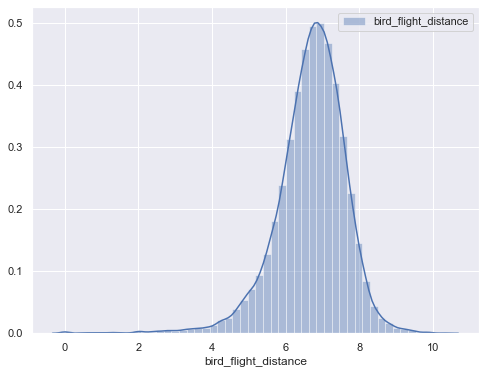

In [598]:
plt.figure(figsize=(8,6))
sns.distplot(np.log(np.maximum(clean_df['bird_flight_distance'], 1)), label='bird_flight_distance')
plt.legend()

- Log-normal distribution
- Any outliers detected easily (needs to look at observations one by one)

## 3. Machine learning
In this section, you have to use a machine learning algorithm to predict the variable `rta`


In [599]:
overview_features(clean_df)

,Nulls,Nulls (%),Type,Cardinality
Feat,,,,
is_from_airport,1554,5.18,object,2
new_is_from_airport,0,0.00,bool,2
surge_was_missing,0,0.00,int64,2
car_type,0,0.00,object,3
surge,0,0.00,float64,9
eta,0,0.00,int64,1262
rta,0,0.00,int64,1465
address,0,0.00,object,20207
bird_flight_distance,0,0.00,float64,29962


- I will sort data by date before splitting. Indeed data is recovered in that way 

In [600]:
clean_df.sort_values(by=['command_date'], ascending=True, inplace=True)

In [601]:
clean_df = clean_df.reset_index(drop=True)

In [602]:
target = ['rta']

categorical_features = ['new_is_from_airport', 'car_type']
continuous_features = ['surge_was_missing', 'surge', 'eta', 'bird_flight_distance']

datetime_feature = ['command_date']

- Before splitting, I add a new column using datetime 

I will recover only hour from the datetime column. I only have one week of data, if I had more I could have added:
- Month
- Weekday
- Weekend or not
...

In [603]:
# Hour
clean_df['hour'] = pd.to_datetime(clean_df.command_date).dt.hour
categorical_features.append('hour')

# Weekend
clean_df['weekend'] = pd.to_datetime(clean_df.command_date).dt.weekday // 5
continuous_features.append('weekend')

In [604]:
X = clean_df[categorical_features + continuous_features]
y = clean_df[target]

#### Split dataset into Train and Test

In [609]:
split_ratio = 0.2
split_index = int(len(X) * (1 - split_ratio))

X_train = X.iloc[: split_index, :]
y_train = y.iloc[: split_index, :]

X_test = X.iloc[split_index:, :]
y_test = y.iloc[split_index:, :]

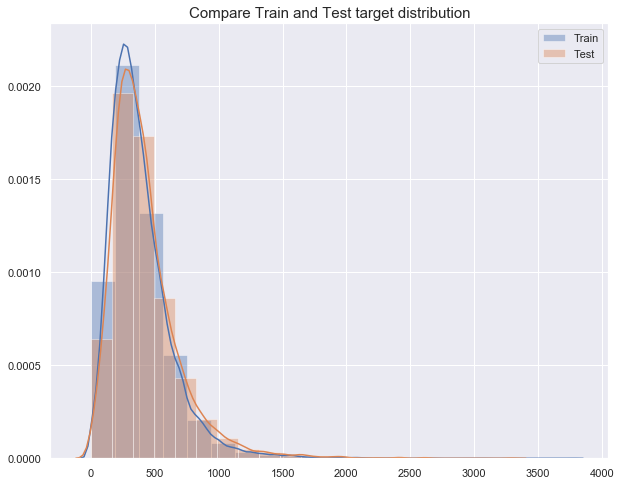

In [610]:
# Check if test and train have same distribution of target

plt.figure(figsize=(10,8))
sns.distplot(y_train.values, bins=20, label='Train')
sns.distplot(y_test.values, bins=20, label='Test')
plt.title('Compare Train and Test target distribution', fontsize=15)
plt.legend(loc='upper right')

- Test and Train target distributions are not very different. I can built a model.

#### Preprocessing categorical features: One hot encoding for feature with low cardinality. 
Concerning the feature "address" which is very important, i removed it since I have no time to dig more on how to use it. But it is undoubtedly a very important feature.

In [611]:
# One hot encode categorical features 
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

def fit_transform(df, istrain, fitter):
    
    if istrain:
        fitter.fit(df)
        
    df_transformed = fitter.transform(df)
    
    return df_transformed


# Train
one_hot_X_train = X_train[categorical_features]

one_hot_X_train = pd.DataFrame(fit_transform(one_hot_X_train, True, one_hot_encoder))
one_hot_X_train.set_axis(one_hot_encoder.get_feature_names(list(X_train[categorical_features].columns)),
                                                           axis=1, inplace=True)
X_train.drop(categorical_features, axis=1, inplace=True)

X_train = pd.concat([X_train, one_hot_X_train], axis=1, sort=False)


# Test
one_hot_X_test = X_test[categorical_features]
one_hot_X_test = pd.DataFrame(fit_transform(one_hot_X_test, False, one_hot_encoder))
one_hot_X_test.set_axis(one_hot_encoder.get_feature_names(list(X_test[categorical_features].columns)),
                                                           axis=1, inplace=True)
one_hot_X_test.reset_index(drop=True, inplace=True)
X_test.drop(categorical_features, axis=1, inplace=True)


X_test = pd.concat([X_test.reset_index(drop=True), one_hot_X_test], axis=1, sort=False)

/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Preprocessing continuous features

Here I scale continuous features to use them for linear models

In [612]:
# Scaling continuous features 
old_X_test = X_test.copy()

minmax_scaler = MinMaxScaler()

feat_to_scale = ['surge', 'eta', 'bird_flight_distance']

# Train
X_train_scaled = pd.DataFrame(fit_transform(X_train[feat_to_scale], True, minmax_scaler), columns=feat_to_scale)
X_train[feat_to_scale] = X_train_scaled

# Test
X_test_scaled = pd.DataFrame(fit_transform(X_test[feat_to_scale], False, minmax_scaler), columns=feat_to_scale)
X_test[feat_to_scale] = X_test_scaled

#### Model

In [487]:
models = [
        RandomForestRegressor(n_jobs=-1),
        LinearRegression(),
        Lasso(),
        XGBRegressor(n_thread=-1)
]

- I need to be careful here before doing a cross validation to choose the right model. Indeed data comes in an order fixed by 'command_date'. 
- Due to lack of time I will split my Train into Train and Validation data sets. I will chose the model that gives me the best MSE score here. I will finally evaluate the model on the Test data set. 
- Here I choose the MSE for the loss to train models. Indeed, since I didn't remove RTA with high value, I want them to be part of the model and influence it

In [618]:
split_validatio_ratio = 0.2 
split_validation_index = int(len(X_train) * (1 - split_validatio_ratio))

X_train_new = X_train.iloc[: split_validation_index, :]
y_train_new = y_train.iloc[: split_validation_index, :]

X_validation = X_train.iloc[split_validation_index:, :]
y_validation = y_train.iloc[split_validation_index:, :]

In [620]:
for model in models:
    model.fit(X_train_new, y_train_new)
    predictions = model.predict(X_validation)
    print(type(model).__name__, '- MSE:', mean_squared_error(y_validation, predictions))


/Users/ddebbaghnour/Documents/Apache_Beam/beam_env_python3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor - MSE: 30821.525866203698
LinearRegression - MSE: 26010.314329427085
Lasso - MSE: 27291.36897728601
[17:04:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor - MSE: 25366.53058075341


- The linear regression performs almost as well as xgboost, it is probably due to ETA which plays a big role in predictions (hence a linear model can perform well)

- Here I will do a gridsearch on very few parameters. (Another gridsearch should be done later with bigger ranges of values, and using other parameters)

In [622]:
params = {'n_estimators': [100, 200, 300, 400], 'max_depth': [2,3,4]}

best_score = 1000000000
best_n_estimators = None
best_max_depth = None

for nbr_est in params['n_estimators']:
    for max_d in params['max_depth']:
        xgb_reg = XGBRegressor(n_estimators=nbr_est, max_depth=max_d)
        xgb_reg.fit(X_train_new, y_train_new)
        predictions = xgb_reg.predict(X_validation)
        mse = mean_squared_error(y_validation, predictions)
        if mse < best_score: 
            best_score = mse
            best_n_estimators = nbr_est
            best_max_depth = max_d

[17:14:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [624]:
print('Best parameters:')
print('best_n_estimators:', best_n_estimators)
print('best_max_depth:', best_max_depth)

Best parameters:
best_n_estimators: 200
best_max_depth: 3


Now that I have chosen the 'best' model, I evaluate it on Test data set

[17:07:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## 4. Your algorithm performance
In this section, you have to describe you algorithm's performance (overfitting, underfitting, good or bad results, ...)

- Here I will compare the model built to the case where we simply use the ETA only
- I will use MAE to compare models and evaluate them (mean value of error made on predictions)

In [626]:
xgb_reg = XGBRegressor(n_estimators=200, max_depth=3)
xgb_reg.fit(X_train, y_train)

[17:20:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [628]:
y_pred_xgb = xgb_reg.predict(X_test)
print('Model prediction {}'.format(mean_absolute_error(y_test, y_pred_xgb)))
print('Using only ETA {}'.format(mean_absolute_error(y_test, old_X_test['eta'])))

Model prediction 111.02071599260967
Using only ETA 125.56283333333333


- Here we see that the model makes better predictions than when using only the ETA. (However we used also the ETA among the features like if it was a stacking model)

In [632]:
# Not using ETA (needs to do another benchmark of models to choose the right one)

xgb_reg_without_eta = XGBRegressor(n_estimators=200, max_depth=3)
xgb_reg_without_eta.fit(X_train.drop('eta', axis=1), y_train)
y_pred_xgb_without_eta = xgb_reg_without_eta.predict(X_test.drop('eta', axis=1))
print('Model prediction {}'.format(mean_absolute_error(y_test, y_pred_xgb_without_eta)))
print('Using only ETA {}'.format(mean_absolute_error(y_test, old_X_test['eta'])))

[17:27:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model prediction 127.96723935381571
Using only ETA 125.56283333333333


- Results are worse than using only ETA

In [634]:
print('Mean value of RTA in y_test: {}'.format(y_test['rta'].mean()))

Mean value of RTA in y_test: 422.18216666666666


- Results here seems bad to me. Indeed MAE is 111 (seconds?) and the mean value of RTA is 422 which is only four times higher than the mean error the model makes. 

- Many improvements have to be done during the preprocessing and feature creation

In [635]:
# Overfitting ?

y_train_predictions = xgb_reg.predict(X_train)

mean_absolute_error(y_train, y_train_predictions)

99.06081467892481

- The model has better results on training data. However the gap on MAE is not that high. I cannot say that the model overfits here

In [636]:
print('Min value of predictions:', min(y_pred_xgb))
print('Max value of predictions:', max(y_pred_xgb))

Min value of predictions: 33.97433
Max value of predictions: 2168.8328


- The model does not predict negative values
- The model does also not predict very low values. The model is safer than others that can predict very low values, then the user gets disapointed

#### Plot mean error distribution

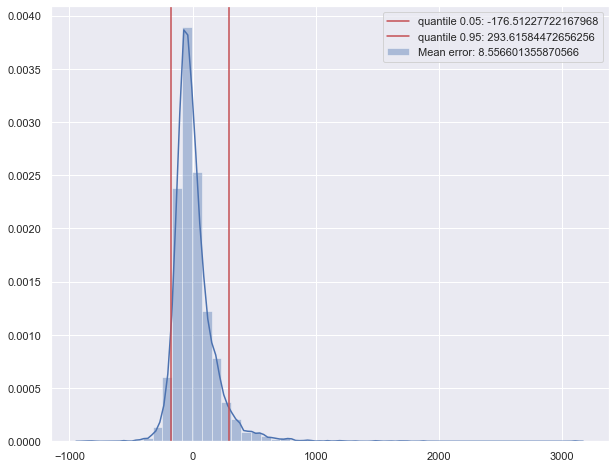

In [638]:
plt.figure(figsize=(10, 8))
errors = y_test['rta'].values - y_pred_xgb
sns.distplot(errors, label='Mean error: {}'.format(np.mean(errors)))
plt.axvline(np.quantile(errors, 0.05), label='quantile 0.05: {}'.format(np.quantile(errors, 0.05)), c='r')
plt.axvline(np.quantile(errors, 0.95), label='quantile 0.95: {}'.format(np.quantile(errors, 0.95)), c='r')
plt.legend()

- We observe that the model sometimes predicts very bad results, which makes the MAE pretty high. 
- we still observe an error distribution looking like a gaussian with a mean close to 0, which is a good point for the model.

## 5. Conclusion
In this section, you can add a final conclusion

The model built above is not performing well. An MAE of 2 minutes is pretty high knowing that the mean RTA is 8 minutes. 

However the model performs better than if we only show the ETA. This model uses the ETA computed by another model, which is not really bothering (need to check also time consumption to make the predictions).

An interesting information was not used here which is the address. Indeed knowing for example the GPS coordinates will simplify the problem. A simple moving weighted average can make some very good predictions. It can also be part of another model as a feature. It will catch if the information about the traffic around the address. Other features can be generated to improve the model.

A more detailled investigation on outliers is necessary to clean our data. Here I couldn't find (in the time given) a pattern that indicates the existence of outliers. Once these outliers detected more carefully, we can use the MAE as a loss for the model (since I consider it as a good evaluation metric).